# Forecasting with Machine Learning

In this final section, we are going to see how adding more information and leveraging the power of ensemble modeling impacts our ability to predict TSLA's stock price. Our baseline score from the ARIMA model is RMSE = 0.053, so our models should be achieving below this value.

In [2]:
import math
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta, datetime

from sklearn.metrics import mean_absolute_error

In [4]:
# Read data
tsla_df = pd.read_csv('TSLA_processed.csv', parse_dates=['Date']) 

# dates df for later use
dates_df = pd.read_csv('TSLA_raw.csv', parse_dates=['Date']) 
dates_df = dates_df[dates_df['Date'] > datetime(2019, 9, 1)]
dates_df = dates_df[['Date']]
dates_df = dates_df.reset_index(drop=True).reset_index().rename(columns={'index':'Day'})

In [66]:
tsla_df.head()

,TSLA(t+1),TSLA,Volume,MACD,MACD_SIGNAL,MACD_HIST,MOMENTUM,RSI,EMA,MA10,...,STD_DEV(t-1),SPY(t-1),Sentiment Score(t-1),Comment Volume(t-1),Day(t-1),Monthday(t-1),Week(t-1),Weekday(t-1),Month(t-1),Year(t-1)
0,-0.009321,0.039538,0.522077,0.176652,0.059398,0.117253,2.785999,7.192328,0.001052,0.003984,...,-0.280315,0.011287,0.583838,0.506230,1.0,4.0,35.0,3.0,9.0,19.0
1,0.018901,-0.009321,0.448726,0.110307,0.069580,0.040727,-0.689999,-1.761905,0.000376,0.002405,...,-0.131486,0.012773,0.583838,0.506230,2.0,5.0,35.0,4.0,9.0,19.0
2,0.016049,0.018901,0.506604,0.160295,0.087723,0.072572,3.018002,3.297713,0.001588,0.009200,...,-0.062968,0.000772,0.583838,0.506230,3.0,6.0,35.0,5.0,9.0,19.0
3,0.047912,0.016049,0.498537,0.188220,0.107823,0.080398,0.029999,2.690668,0.002549,0.009183,...,0.259945,0.000503,0.665584,0.507393,4.0,9.0,36.0,1.0,9.0,19.0
4,-0.004990,0.047912,0.575493,0.332557,0.152770,0.179788,2.495995,7.018949,0.005649,0.014588,...,0.254411,-0.000235,0.665584,0.506230,5.0,10.0,36.0,2.0,9.0,19.0


# Random Forest

Our first machine learning model will be a Random Forest, which is an ensemble model of decision trees.

#### Train Model

In [67]:
from sklearn.ensemble import RandomForestRegressor

In [68]:
training_size = 350
horizon = 1

# Training data
tsla_df = pd.read_csv('TSLA_processed.csv')
X = tsla_df.iloc[:training_size-horizon,1:]
y = tsla_df.iloc[:training_size-horizon,0]    

# Random Forest 
regr = RandomForestRegressor(n_estimators=100, random_state=0)
regr.fit(X, y)     

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

Below, we can visualize the relative feature importance for our top variables in the random forest fit to the training set.

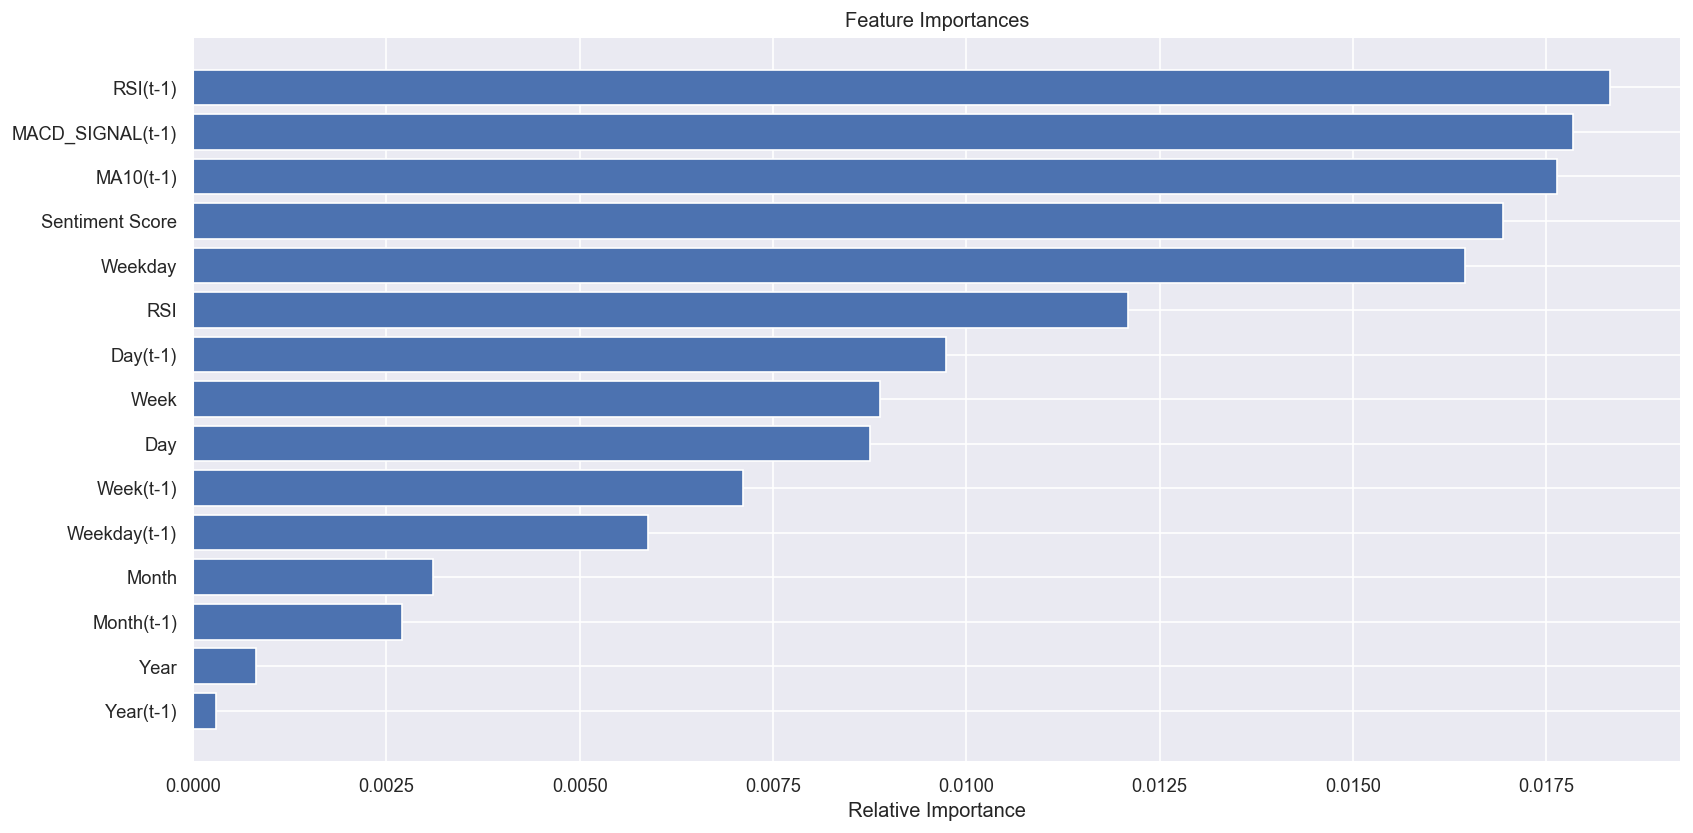

In [69]:
# Feature Importance
features = list(tsla_df.columns)[1:]
importances = regr.feature_importances_
indices = np.argsort(importances)

# Top Features
indices = indices[:15]

sns.set(rc={'figure.figsize':(16, 8)})

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

#### Test model on last month of data

In [70]:
# Random Forest   
training_size = 350

# Split train and test sets (test = 30 days)
X = tsla_df.iloc[:,1:]
y = tsla_df.iloc[:,0] 
X_train, X_test = X.iloc[0:training_size,:], X.iloc[training_size:X.shape[0],:]
y_train, y_test = y[0:training_size], y[training_size:len(y)]

# train model
regr = RandomForestRegressor(n_estimators=100, random_state=0)
regr.fit(X_train, y_train)  

train_pred = regr.predict(X_train)
y_true = y_train.values
test_pred = []

# walk-forward predictions 
for t in range(training_size, X.shape[0]-1):
    regr.fit(X.iloc[:t,:], y[:t]) 
    yhat = regr.predict(X.iloc[t,:][:,None].T) #reshape with broadcasting
    test_pred.append(yhat)
    obs = y[t]
rmse = math.sqrt(mean_squared_error(y_test.values[:-1], test_pred))
print(f"Test RMSE: {round(rmse, 3)}")

Test RMSE: 0.046


The Random Forest outperformed our ARIMA model's baseline of 0.053 by 13% with an RMSE of 0.046.

#### Plot Test Predictions

In [71]:
# Prep predictions for visual
train_pred = [i for i in train_pred]
test_pred = [i[0] for i in test_pred]
pred = train_pred + test_pred
pred = pd.Series(pred)
pred_df = pd.DataFrame({'Day':pred.index, 'Price':pred})

# Add 1 Day index for one-day forecast predictions
pred_df['Day'] +=1
pred_df.index += 1

In [72]:
# Recover Price from predictions
tsla_prices = pd.read_csv('TSLA_raw.csv', parse_dates=['Date'])
tsla_prices = tsla_prices[tsla_prices['Date'] > datetime(2019, 9, 1)].reset_index(drop=True)

# Get series of prices - lagging by 1 to account for differencing
tsla_prices = np.log(tsla_prices['TSLA'])[1:].reset_index(drop=True) 

pred_df = pred_df.merge(tsla_prices.to_frame(), left_index=True, right_index=True)
pred_df['Price'] = pred_df['Price'] + pred_df['TSLA']

pred_df['Recovered Price'] = np.exp(pred_df['Price'])
pred_df['Type'] = 'Predicted'
pred_df = pred_df.drop('TSLA', axis=1)
pred_df = pred_df.rename(columns={'Recovered Price':'TSLA'})
pred_df = pred_df[['Day','TSLA','Type']]

In [73]:
obs_df = pd.read_csv('TSLA_raw.csv', parse_dates=['Date'])
obs_df = obs_df[obs_df['Date'] > datetime(2019, 9, 4)].reset_index(drop=True) # drop first 3 values
obs_df['Type'] = 'Observed'
obs_df['Day'] = obs_df.index
obs_df = obs_df[['Day','TSLA','Type']]
rf_pred = pd.concat([obs_df, pred_df], ignore_index=True, sort=False)

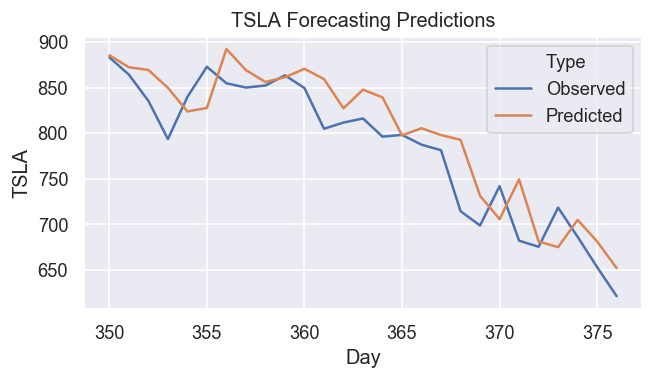

In [74]:
plt.rcParams.update({'figure.figsize':(6,3), 'figure.dpi':120})

# Plot
sns.lineplot(data= rf_pred[rf_pred['Day'] > 349], x="Day", y="TSLA", hue="Type")
plt.title("TSLA Forecasting Predictions")
plt.show()

# XGBoost

Next, we will be training an XGBoost model. Like the Random Forest, this is a decision tree based ensemble model. The distinguishing difference is that XGBoost uses a gradient boosting framework. 

In [76]:
import xgboost
from sklearn.model_selection import GridSearchCV

Let's train our XGBoost model and use GridSearch to select the best parameters. (This may take a while to run)

In [77]:
training_size = 350
horizon = 1

# Training data
X = tsla_df.iloc[:training_size-horizon,1:]
y = tsla_df.iloc[:training_size-horizon,0] 

# Parameters
params = {'colsample_bytree':[0.4,0.6,0.8],
         'gamma':[0,0.03,0.1,0.3],
         'min_child_weight':[1.5,6,10],
         'learning_rate':[0.1,0.07],
         'max_depth':[3,5],
         'n_estimators':[100],
         'reg_alpha':[1e-5, 1e-2,  0.75],
         'reg_lambda':[1e-5, 1e-2, 0.45],
         'subsample':[0.6,0.95],
         'random_state':[0]} 

# XGBoost  
regr = GridSearchCV(xgboost.XGBRegressor(), params)
regr.fit(X, y)     

In [ ]:
regr.best_params_

In [ ]:
# {'colsample_bytree': 0.8,
#  'gamma': 0.1,
#  'learning_rate': 0.1,
#  'max_depth': 3,
#  'min_child_weight': 1.5,
#  'n_estimators': 100,
#  'random_state': 0,
#  'reg_alpha': 1e-05,
#  'reg_lambda': 1e-05,
#  'subsample': 0.6}

In [79]:
# XGBoost   
training_size = 350

params = {'colsample_bytree': 0.8,
         'gamma': 0.1,
         'learning_rate': 0.1,
         'max_depth': 3,
         'min_child_weight': 1.5,
         'n_estimators': 100,
         'random_state': 0,
         'reg_alpha': 1e-05,
         'reg_lambda': 1e-05,
         'subsample': 0.6,
         'random_state':0}

#params = {'n_estimators': 100, 'random_state':0}

# Split train and test sets (test = 30 days)
X = tsla_df.iloc[:,1:]
y = tsla_df.iloc[:,0] 
X_train, X_test = X.iloc[0:training_size,:], X.iloc[training_size:X.shape[0],:]
y_train, y_test = y[0:training_size], y[training_size:len(y)]

# train model
regr = xgboost.XGBRegressor(**params)
regr.fit(X_train.values, y_train)  

train_pred = regr.predict(X_train.values)
y_true = y_train.values
test_pred = []

# walk-forward predictions (except last record)
for t in range(training_size, X.shape[0]-1):
    regr.fit(X.iloc[:t,:].values, y[:t]) 
    yhat = regr.predict(X.iloc[t,:][:,None].T) #reshape with broadcasting
    test_pred.append(yhat)
    obs = y[t]
rmse = math.sqrt(mean_squared_error(y_test.values[:-1], test_pred))
print(f"Test RMSE: {round(rmse, 3)}")

Test RMSE: 0.044


The XGBoost model outperformed our ARIMA model's baseline of 0.053 by 17% with an RMSE of 0.044.

# LSTM 

Finally, we will be training a Long Short Term Memory network. These are usually just called “LSTMs”. They are a special kind of RNN, selectively remembering (or forgetting) patterns for long durations of time. Their feedback connections make them capable of processing entire sequences of data (i.e. speech, video) instead of single data points. This makes LSTMs well-suited for making predictions on time series data.

In [15]:
# LSTM
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [16]:
import tensorflow as tf

In [29]:
# Move target variable to the end
tsla_cols = ['TSLA', 'Volume', 'MACD', 'MACD_SIGNAL', 'MACD_HIST',
       'MOMENTUM', 'RSI', 'EMA', 'MA10', 'MA21', 'MA50', 'STD_DEV', 'SPY',
       'Sentiment Score', 'Comment Volume', 'Day', 'Monthday', 'Week', 'Weekday',
       'Month', 'Year','TSLA(t+1)']
tsla_df = tsla_df[tsla_cols]

#### Data Prep

In [31]:
# Training data
training_size = 350
df = tsla_df.copy()

# Drop last record without value for target variable
df = df.iloc[:-1,:]

# train - test split
train_df, test_df = df.iloc[:training_size, :], df.loc[training_size:, :]

In [32]:
# Prep data
values = df.values
values = values.astype('float64')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

#### Define and Fit Model

In [36]:
# Fit an LSTM with our multivariate input data
values = scaled
n_train_days = 350
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(350, 1, 21) (350,) (26, 1, 21) (26,)


We will define the LSTM with 50 neurons in the first hidden layer and 1 neuron in the output layer for predicting TSLA's price. The input shape will be 1 time step with 26 features.

The model will be fit for 50 training epochs with a batch size of 5. The internal state of the LSTM in Keras is reset at the end of each batch, so an internal state that is a function of a number of days may be helpful, in this case 5 days (one week in the stock market).


Train on 350 samples, validate on 26 samples
Epoch 1/50
 - 1s - loss: 0.1166 - val_loss: 0.0942
Epoch 2/50
 - 0s - loss: 0.0945 - val_loss: 0.0915
Epoch 3/50
 - 0s - loss: 0.0919 - val_loss: 0.0850
Epoch 4/50
 - 0s - loss: 0.0896 - val_loss: 0.0813
Epoch 5/50
 - 0s - loss: 0.0894 - val_loss: 0.0827
Epoch 6/50
 - 0s - loss: 0.0883 - val_loss: 0.0810
Epoch 7/50
 - 0s - loss: 0.0872 - val_loss: 0.0878
Epoch 8/50
 - 0s - loss: 0.0853 - val_loss: 0.0895
Epoch 9/50
 - 0s - loss: 0.0851 - val_loss: 0.0880
Epoch 10/50
 - 0s - loss: 0.0849 - val_loss: 0.0864
Epoch 11/50
 - 0s - loss: 0.0853 - val_loss: 0.0912
Epoch 12/50
 - 0s - loss: 0.0854 - val_loss: 0.0900
Epoch 13/50
 - 0s - loss: 0.0849 - val_loss: 0.0882
Epoch 14/50
 - 0s - loss: 0.0849 - val_loss: 0.0884
Epoch 15/50
 - 0s - loss: 0.0850 - val_loss: 0.0864
Epoch 16/50
 - 0s - loss: 0.0843 - val_loss: 0.0864
Epoch 17/50
 - 0s - loss: 0.0838 - val_loss: 0.0846
Epoch 18/50
 - 0s - loss: 0.0848 - val_loss: 0.0830
Epoch 19/50
 - 0s - loss: 0

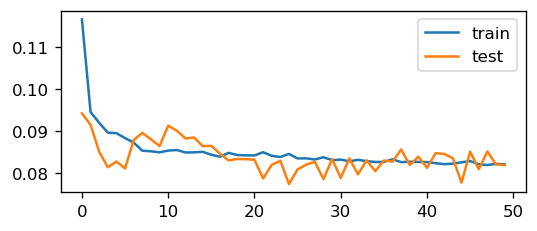

In [37]:
# Now we can define and fit our LSTM model.
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=5, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

#### Evaluate Model

In [75]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.043


The LSTM outperformed our ARIMA model's baseline of 0.053 by 19% with an RMSE of 0.043.

In conclusion, there is still much variation that is unaccounted for in our models. It may benefit us to collect more sentiment data from Twitter or news articles in a future iteration. However, we are able to outperform our ARIMA baseline in all three models and the LSTM is our champion model, outperforming our Random Forest and XGBoost models by 6.5% and 2.3%, respectively.